In [14]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import seaborn as sns
import imp
import matrixes
imp.reload(matrixes)
import random_initialization as rand_init
imp.reload(rand_init)

<module 'random_initialization' from 'C:\\Users\\ALemikhov\\Documents\\Slb research\\01_ResModel\\random_initialization.py'>

# Reservoir model

Задача - построить 2D модель резервуара. Для начала необходимо задать свойства полости, такие как $\phi,\ S_{water}, S_{oil} = 1 - S_{water}, c_r, c$. Также величины, фигурирующие в законе Дарси: $k, \mu, \rho$. Будем считать модель изотропной и варьировать лишь $S_{oil}$

# Построение формы резервуара
## Насыщение
Будем задавать значения каким -нибудь рандомным способом, но красивым. В `sklearn` есть множество методов создания выборок для классификации, мне понравился этот. Так мы и будем определять где вода, а где нефть.

In [15]:
ns = 50000
x_min, x_max = -1.3, 1.3
y_min, y_max = -1.3, 1.3

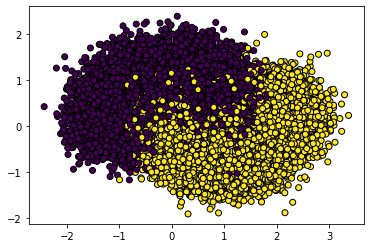

In [16]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()          

Перенесём всё это на меньший сетку фиксированного размера c фиксированным шагом по следующим правилам
<ol>
<li>Если в ячейке не оказывается ни одного элемента - значит это не пористая структура.

<li>Если оказывается несколько - берёс среднее арифметическое
</ol>

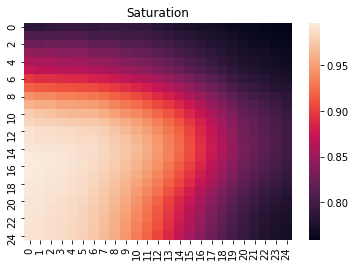

In [17]:
Satur_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=1, x_min=-1,
                                                 y_min=-1, y_max=1
                                                )
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

# Глубина
Покачто у нас резервуар 2D и вид сверху, нужно задать функцию глубины.

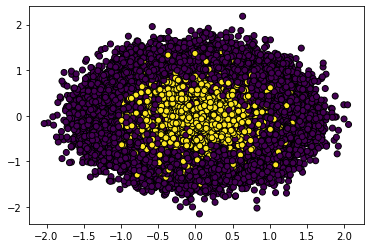

In [18]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()    

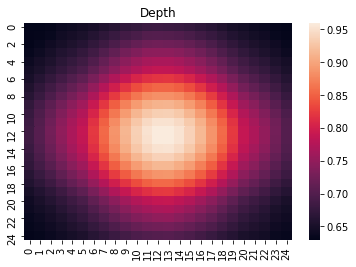

In [19]:
depth_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

# Пористость
Возьмём её пока такую же как матрицу проницаемости

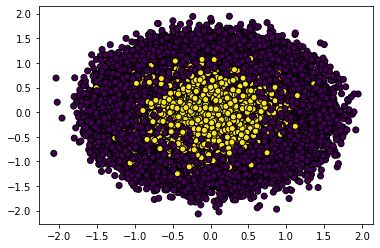

In [20]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

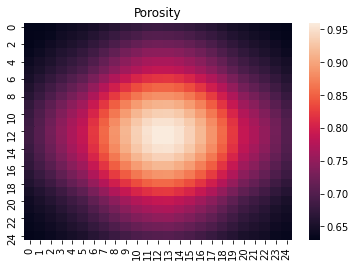

In [21]:
porosity_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("Porosity")
plt.show()

# Проницаемость k
Возьмём такую же как матрицу насыщений

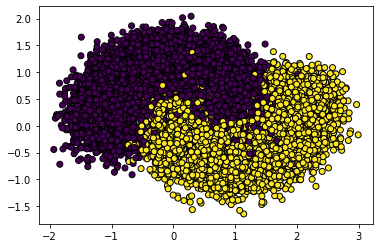

In [22]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()     

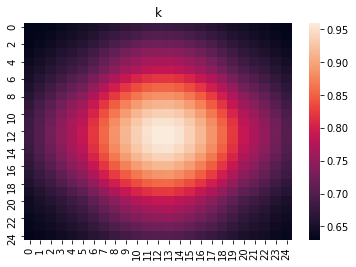

In [23]:
k_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("k")
plt.show()

## Матрицы свойств собраны
Для построения модели эти матрицы нужно вытянуть в матрицы размера $n_x \cdot n_y$, сделать около диагональными и уметь обращаться к свойствам резервуара на границе ячеек для матриц $k$ и $depth$

Для $k$ в лекции вывели формулу, её реализаия представлена в классе `KMatrix`. 

$$k_{i+\frac{1}{2}, j} = \frac{\Delta x_{i, j} + \Delta x_{i+1, j}}{\frac{\Delta x_{i, j}}{k_{i, j}} + \frac{\Delta x_{i+1, j}}{k_{i+1, j}}}$$
\
\
$$k_{i, j+\frac{1}{2}} = \frac{\Delta y_{i, j} + \Delta y_{i, j+1}}{\frac{\Delta y_{i, j}}{k_{i, j}} + \frac{\Delta y_{i, j+1}}{k_{i, j+1}}}$$

### Глубина тоже важна на стыках
Аккуратненько реализуем 
$$d_{i,\ j+\frac{1}{2}} = \frac{d_{i, j} + d_{i, j+1}}{2}$$
\
\
$$d_{i+\frac{1}{2},\ j} = \frac{d_{i, j} + d_{i+1, j}}{2}$$

# Модель
$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = {\frac{\partial}{\partial x} \big(\frac{k k_{ro}}{\mu_o B_o}\frac{\partial \vec p}{\partial x}\big)} + \tilde
{q_o}$$
И точно такое же но для индекса не `o`, означающего `oil` а для `w`, `water`

Рассписав $\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o}$ по `chain rule`

$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = \frac{\phi}{B_o} \frac{\partial S_o}{\partial t} + \big( \frac{\phi S_o}{B_o} B_o \frac{\partial}{\partial p}\big[ \frac{1}{B_o} \big]  + \frac{\phi S_o}{B_o} \cdot \frac{1}{\phi} \frac{\partial \phi}{\partial p} \big) \frac{\partial p}{\partial t}$$ (1)

Введём константы сжимаемости

$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = \frac{\phi}{B_o} \frac{\partial S_o}{\partial t} + \big( \frac{\phi S_o}{B_o} c_o  + \frac{\phi S_o}{B_o} c_r \big) \frac{\partial p}{\partial t}$$

Пока поставим себе цель обновлять давление в нашей 2D картинке. Нужно избавиться от насыщений. Домножим выражение 1 на $\frac{B_o}{B_w}$. Во многих местах окажется сумма насыщений.

$$\frac{\phi}{B_w} \frac{\partial}{\partial t} \big(S_w + S_o\big) + \frac{\phi}{B_w}\big[ S_{o}c_o + S_{w}c_w + c_{r} (S_o + S_w)\big] \frac{\partial p}{\partial t} = \big(\frac{B_o}{B_w} \frac{k k_{ro}}{\mu_o B_o} +  \frac{k k_{rw}}{\mu_w B_w}\big) \nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$

Учтём что $S_w + S_o = 1$. Это достигается постоянством давления на границе и потоком воды ($\tilde{q}$ нужно только на границе, в других местах 0).

Заменим $S_{o}c_o + S_{w}c_w + c_{r} (S_o + S_w) = c_t$ и получим:

$$\frac{\phi c_t}{B_w} \frac{\partial p}{\partial t} = \big(\frac{k k_{ro}}{\mu_o B_w} + \frac{k k_{rw}}{\mu_w B_w} \big) \nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$
\


## Обновление давления
$$\frac{\phi c_t}{B_w} \frac{\partial p}{\partial t} = \tilde{k}\nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$

Точно такое же уравнение было решено [Here](https://www.youtube.com/watch?v=2hxV5kJojRM&list=PLKNU3sBDzHbI4qD55I189y02asrHrgz6_&index=2). Перепишем ответ

$$\frac{\phi c_t}{B_w}\frac{p_{i, j}^{n+1} - p_{i,j}^{n}}{\Delta t} \Delta V_{i, j}=
\Big( \\
\tilde{k}_{i+\frac{1}{2}, j} d_{i+\frac{1}{2}, j} \Delta y_{j} \frac{p_{i+1, j} - p_{i, j}}{\Delta x_{i+\frac{1}{2}}} +\\
\tilde{k}_{i-\frac{1}{2}, j} d_{i-\frac{1}{2}, j} \Delta y_{j} \frac{p_{i-1, j} - p_{i, j}}{\Delta x_{i-\frac{1}{2}}} + \\
\tilde{k}_{i-\frac{1}{2}, j} d_{i, j+\frac{1}{2}} \Delta x_{i}  \frac{p_{i, j+1} - p_{i, j}}{\Delta y_{j+\frac{1}{2}}} + \\
\tilde{k}_{i-\frac{1}{2}, j} d_{i, j-\frac{1}{2}} \Delta x_{j}  \frac{p_{i, j-1} - p_{i, j}}{\Delta y_{j-\frac{1}{2}}}
\Big)\\
+ \tilde{Q}$$
\
$\Delta V_{i, j} = \Delta x_{i, j} \Delta y_{i, j} d_{i,j}$


### T Interblock matrix
Теперь можно для каждого стыка ячеек можно указать "проводимость"
$$T_{i+\frac{1}{2}, j} =\tilde{k}_{i+\frac{1}{2}, j} d_{i+\frac{1}{2}, j} \frac{ \Delta y_{j}}{\Delta x_{i+\frac{1}{2}}}$$
\
\
$$T_{i, j+\frac{1}{2}} =\tilde{k}_{i, j+\frac{1}{2}} d_{i, j+\frac{1}{2}} \frac{ \Delta x_{j}}{\Delta y_{i+\frac{1}{2}}}$$

Также обозначим $B^{p, w}_{i, j} = \frac{\phi_{i, j}c_t V_{i, j}}{B_{w}}$

Эта матрица реализованна в классе `matrixes.TInterBlockMatrix`

### Матрица для обновлений

Для того чтобы обновлять значения в ячейках, используя матричные умножения, нужно превратить матрицу свойств в вектор(reshape(-1)). Матрица же для обновления будет очень хитрой.

#### .reshape(-1)

In [24]:
x = np.array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8]
             ])
x.reshape(-1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [25]:
x.reshape((3, 3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

### Матрица обновлений

$$B_{i, j}^{p, w}\frac{p_{i, j}^{n+1} - p_{i,j}^{n}}{\Delta t} +
T_{i+\frac{1}{2}, j} (p_{i, j} - p_{i+1, j}) +
T_{i-\frac{1}{2}, j} (p_{i, j} - p_{i-1, j}) + 
T_{i, j+\frac{1}{2}} (p_{i, j} - p_{i, j+1}) + 
T_{i, j-\frac{1}{2}} (p_{i, j} - p_{i, j-1}) + 
\tilde{Q}= 0$$

Перейдём от $p_{i, j}$ к $p_n$

$$p_{i, j} = p_{n_y \cdot i + j}$$

$$B_{n_y \cdot i + j}^{w}\frac{p_{n_y \cdot i + j}^{n+1} - p_{n_y \cdot i + j}^{n}}{\Delta t} +\\
T_{i+\frac{1}{2}, j} (p_{n_y \cdot i + j} - p_{n_y \cdot (i+1) + j}) +\\
T_{i-\frac{1}{2}, j} (p_{n_y \cdot i + j} - p_{n_y \cdot (i-1) + j}) + \\
T_{i, j+\frac{1}{2}} (p_{n_y \cdot i + j} - p_{n_y \cdot i + j+1}) + \\
T_{i, j-\frac{1}{2}} (p_{n_y \cdot i + j} - p_{n_y \cdot i + j-1}) + \\
\tilde{Q} = 0$$

Сделаем $B^{p, w}$ диагональную матрицу

$B^{p, w} \frac{\partial \vec{p}}{\partial t} + T_{matrix} \vec{p} + \frac{B_o}{B_w}\tilde{q_o} \Delta V_{n_y \cdot i + j} + \tilde{Q}$

Но как же устроена $T_{matrix}$?

$$
\begin{pmatrix}
B^{p, w}_{0} & 0 &\dots \\
0 & B^{p, w}_{1} & \dots \\
\vdots &  \vdots & \ddots \\
\end{pmatrix}
\frac{\partial \vec{p}}{\partial t} + 
\begin{pmatrix}
0&0&\ddots&\ddots&\ddots&0&\dots&-T_{i+\frac{1}{2}, j-1}&0 \\
-T_{i-\frac{1}{2}, j}&0&0&-T_{i, j-\frac{1}{2}}&
T_{i+\frac{1}{2},j}+T_{i-\frac{1}{2},j} + T_{i,j+\frac{1}{2}}+T_{i,j-\frac{1}{2}}
&-T_{i, j+\frac{1}{2}}&0&0& -T_{i+\frac{1}{2}, j}\\
0&\ddots&0&0&\ddots&\ddots&\ddots&0&0\\
\end{pmatrix}
\vec{p} +$$
\
\
\
\
$$\tilde{Q}
=0
$$

Матрица получается трёхдиагональная, но есть элементы с отрицательными индексами, или же слишком большими которые должны поддерживать начальные условия

Последнее слагаемое помогает справиться с граничными условиями

<img src="figures/bound_cond1.png">

Про то как разбирать граничные условия можно глянуть [тут](https://www.youtube.com/watch?v=XexrRtDcMaI&list=PLKNU3sBDzHbLrx0my5my11XODkYpgP-iO&index=3)

По рисунку выше составим граничные условия

Для начала разберём случай не угловой клетки
$$Q_{(i, -1) -> (i, 0)} = T_{i, -\frac{1}{2}} \big( P_{i, -1} - P_{i, 0} \big) = 2 T_{0} \big( P_{b} - P_{i, 0}\big)$$

Следовательно $T_{-\frac{1}{2}, j} = 2T_{0, j}$

Добавка к $Q_{0, 0} = 2T_{0, j} P_{b}$

Аналогично:
<table>
    <tr>
        <td>
\begin{eqnarray}
T_{n_x - \frac{1}{2}, j} = 2T_{n_x - 1, j}\\
T_{i, n_y - \frac{1}{2}} = 2T_{i, n_y - 1}\\
T_{-\frac{1}{2}, j} = 2T_{0, j}\\
T_{i, -\frac{1}{2}} = 2T_{i, 0}\\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
Q_{n_x - 1, j} = 2T_{n_x - 1, j} P_b \\
Q_{i, n_y - 1} = 2T_{i, n_y - 1} P_b\\
Q_{0, j} = 2T_{0, j} P_b\\
Q_{i, 0} = 2T_{i, 0} P_b\\
\end{eqnarray}
        </td>
    </tr>
</table>

В 4 угловые точки никогда не попадём

Вектор Q и его создание реализованно в `matrixes.get_q_p`, где p означает что этот вектор обозначен в разделе, где рассматривается обновление давления

Матрица T для обнолвнеий реализована функцией `matrixes.get_t_upd_matrix`

## Обновление насыщения

Воспользаемся уже полученным уравнением
$$\frac{\phi}{B_w} \frac{\partial S_w}{\partial t} +\frac{\phi S_w}{B_w}\big(c_w + c_r \big) \frac{\partial p}{\partial t} = 
\frac{\partial}{\partial x}\Big[ \frac{k k_{rw}}{\mu_w B_w} \frac{\partial p}{\partial x} \Big] + \tilde{q_w}$$

$ \frac{k k_{rw}}{\mu_w B_w} = k^{s, w}$

$$\frac{\phi}{B_w} \frac{\partial S_w}{\partial t} +\frac{\phi S_w}{B_w}\big(c_w + c_r \big) \frac{\partial p}{\partial t} = 
\frac{\partial}{\partial x}\Big[ k^{s, w}\frac{\partial p}{\partial x} \Big] + \tilde{q_w}$$

Обозначим $B^{s, w}_{i, j} = \frac{\phi_{i, j} (c_w + c_r) V_{i, j}}{B_{w}}$

Точно такое же уравнение было решено [Here](https://www.youtube.com/watch?v=2hxV5kJojRM&list=PLKNU3sBDzHbI4qD55I189y02asrHrgz6_&index=2). Перепишем ответ

$$\frac{\phi}{B_w}\frac{S_{w; i, j}^{n+1} - S_{w; i, j}^{n}}{\Delta t} \Delta V_{i, j} + 
B^{s, w}_{i, j} \frac{p^{n+1}_{i, j} - p_{i, j}^n}{\Delta t} * \vec{S^{n+1}} =
\Big( \\
k^{s, w}_{i+\frac{1}{2}, j} d_{i+\frac{1}{2}, j} \Delta y_{j} \frac{p_{i+1, j} - p_{i, j}}{\Delta x_{i+\frac{1}{2}}} +\\
k^{s, w}_{i-\frac{1}{2}, j} d_{i-\frac{1}{2}, j} \Delta y_{j} \frac{p_{i-1, j} - p_{i, j}}{\Delta x_{i-\frac{1}{2}}} + \\
k^{s, w}_{i-\frac{1}{2}, j} d_{i, j+\frac{1}{2}} \Delta x_{i}  \frac{p_{i, j+1} - p_{i, j}}{\Delta y_{j+\frac{1}{2}}} + \\
k^{s, w}_{i-\frac{1}{2}, j} d_{i, j-\frac{1}{2}} \Delta x_{j}  \frac{p_{i, j-1} - p_{i, j}}{\Delta y_{j-\frac{1}{2}}}
\Big)\\
+ \tilde{Q}$$
\
$\Delta V_{i, j} = \Delta x_{i, j} \Delta y_{i, j} d_{i,j}$


В уравнениее обновления насыщенности воды фигурирует всё слагаемое для граничных условий т.к. затекает в резервуар извне только вода.

Перепишем всэ это в матричном виде

$$\frac{\phi}{B_w}\frac{\partial \vec{S_w}}{\partial t} \Delta V_{i, j} + B^{s, w} \frac{\partial p}{\partial t} * \vec{S_w} + T^{upd}_{k^{s,w}} \vec{p} = \tilde{Q^w}
$$

$$\frac{\phi}{B_o}\frac{\partial \vec{S_o}}{\partial t} \Delta V_{i, j} + B^{s, o} \frac{\partial p}{\partial t} * \vec{S_o} + T^{upd}_{k^{s, o}} \vec{p} = \tilde{Q^o}
$$

Будем каждый шаг обновлять насыщения и нефти и воды, а потом нормировать на сумму. Чтобы случайно численные методы не привели к тому что $S_o + S_w \neq 1$

Обозначу константы, которым я ранее не уделил достаточно времени:
<ol>
    <li> $B^w = \frac{water\ volume\ in\ res}{water\ volume\ standart}$
    <li> k - пропускная способность
    <li> $\mu$ - вязкость
    <li> $\phi$ - пористость
    <li> $S$ - насыщённсоть
    <li> $k_{r, \alpha}$ - относительно пропускная способность
    <li> $c_t = S_{o}c_o + S_{w}c_w + c_{r}$
    <li> $B^{p, w}_{i, j} = \frac{\phi_{i, j}c_t V_{i, j}}{B_{w}}$
    <li> $B^{s, w}_{i, j} = \frac{\phi_{i, j} (c_w + c_r) V_{i, j}}{B_{w}}$
    <li> $\tilde{k} = \frac{k k_{ro}}{\mu_o B_w} + \frac{k k_{rw}}{\mu_w B_w}$
</ol>

# Моделирование скважины
Остался последний штих

Первый подход - задавать $q$ на каждом входе манары.
При этом нужно фиксировать суммарную пропускную способность.

Таким образом мы сможем узнавать сколько проходит воды или нефти по значениемм $S_w,\ S_o$ в каждой ячейке.
Однако в таком случае всё машинное обучение сведётся к настройке лишь на эти параметры, не учитывая давление.

## Корректировка давления при скважине
Положим что вход в МАНАРу это сферический шарик одинаково проводящий. Тогда вблизи входа можно записать уравнение рассеяния

$$\lim_{r \rightarrow 0} 4\pi r^2 \cdot \frac{\partial p}{\partial r} = \frac{-q_{\alpha} B_{\alpha}\mu_{\alpha}}{k_{\alpha}}\\
q_{\alpha} \leq 0
$$
$$p(r) = p_0 + \frac{-q_{\alpha} B_{\alpha}\mu_{\alpha}}{4 \pi k_{\alpha}} \cdot \frac{1}{r}$$
Такая зависимость крайне интересна, но представляется собой плохо, т.к. содержит неопределённость. В окресности самой скважины давление фиксировано

<img src="figures/well_fixed_hyp.jpg" style="width: 500px;"/>

Мы сдвигаем гиперболу влево, таким образом в нуле у нас значение давления в трубе $P_{well}$.

При этом давление на бесконечности выравнивается в $P_{avg}$ среднее за соседние 8 ячеек

Обозначим рефересные давление и радиус через равенство заштризованых площадей. Иначе площадь прямоугольника равна площади кривой огрниченной $\Delta x$

$$p(r) = p_{0} - \frac{-q_{\alpha} B_{\alpha}\mu_{\alpha}}{4 \pi k_{\alpha}} \cdot \frac{1}{r}$$
$$p_w = p_0 - \frac{-q_{\alpha} B_{\alpha}\mu_{\alpha}}{4 \pi k_{\alpha}} \cdot \frac{1}{r_w}$$
Так можно получить выражение для константы $p_0$

Нам неизвестно $r_0$ будем находить его, связав $q_{\alpha}$ с тем как жидкость вытекает из ячейки со скважиной в соседние 4, выраженую через разность давлений

<img src="figures/well_neibours.jpg" style="width: 500px;"/>

Обозначим ячейку со скважиной номером $l$, соседей обозначим 1-4. Не забудем про номера ячеек по горизонтали и вертикали. И запишем сколько жидкости втекает в ячейку $\texttt{l}$

$$
q_{\alpha} = -\frac{kd}{\mu_{\alpha}B_{\alpha}} \Big(
\sum_{i=1}^4\big[ p_0 - \frac{-qB_{\alpha}\mu_{\alpha}}{4\pi k_{\alpha}}\cdot \frac{1}{\Delta x} \big]
 - 4p(r_{ref})\Big)$$
$p(r_{ref})$ нам нужно чтобы оценить давление в ячейке и дальше оценивать расход.
$$
q_{\alpha} = -\frac{kd}{\mu_{\alpha}B_{\alpha}} \Big(
\sum_{i=1}^4\big[ p_0 - \frac{-qB_{\alpha}\mu_{\alpha}}{4\pi k_{\alpha}}\cdot \frac{1}{\Delta x} \big]
 - 4\big( p_0 - \frac{-qB_{\alpha}\mu_{\alpha}}{4\pi k_{\alpha}}\cdot \frac{1}{r_{ref}}\big)\Big)
$$
$$
1 = d \Big( - \frac{1}{\pi \Delta x}
 + \frac{1}{\pi r_{ref}}\Big)
$$

$$
r_{ref} = \frac{1}{\frac{1}{\Delta x} + \frac{\pi}{d}}$$

Таким образом $p_l = p_w + \frac{-q_{\alpha}B_{\alpha}\mu_{\alpha}}{4\pi k_{\alpha}}\big[\frac{1}{r_w} - \frac{1}{r_{ref}} \big]$.

$p_{l}$ - получим из разностного решения. $p_w$ - заданная изначально величина. Получается можно расчитывать $q_{\alpha}$

$$
-q_{\alpha} = (p_{l} - p_{w}) \cdot \frac{4\pi k_{\alpha}}{B_{\alpha}\mu_{\alpha}} \cdot \frac{r_w r_{ref}}{r_w - r_{ref}}=\\
(p_{l} - p_{w}) \cdot J_l^{\alpha}
$$
Ах да, $r_{ref}$ зависит от глубины, тоесть зависит от ячейки

Можно разбить это $q$ на 2 слагаемых и засунуть в $\tilde{Q}_{i, j} += J^{\alpha}_{i, j} p_w$ 

# Собираем разносные схемы!
Нужно сделать поправки в формулу обновления давления на $q^{well}$

$$B^{p, w} \frac{\partial \vec{p}}{\partial t} + T^{upd}_{\tilde{k}} \vec{p} + \big[ J^w + \frac{B_o}{B_w} J^{o} \big] \vec{p} = \tilde{Q}^{p} + \frac{B_o}{B_w} q_{o, const\ rate}^{well} + q_{o, const\ rate}^{well}$$
Здесь мы разобрали по частям $q_{const\ press}$ чтобы сделать схему неявной


$$\frac{\phi}{B_w}\frac{\partial \vec{S_w}}{\partial t} \Delta V_{i, j} + S_w * B^{s, w} \frac{\partial p}{\partial t}+ 
T^{upd}_{k^{s,w}} \vec{p} = 
\tilde{Q}^{w} + \vec{q^{well}}_{w, const\ rate} + \vec{q^{well}}_{w, const\ press}
$$


Осталось реализовать все константы и решить уравнения!

$$\Big[ I + \Delta t \big[ B^{p, w} \big]^{-1} T_{\tilde{k}}^{upd} + \Delta t\big[ J^w +\frac{B_o}{B_w} J^{o} \big] \Big]\vec{p^{n+1}}=
\vec{p^{n}} + \Delta t \big[ B^{p, w} \big]^{-1} \Big[ \tilde{Q} + \frac{B_{o}}{B_{w}}q_{o}^{well} + q_{w}^{well} \Big]
$$

$$\big[I + \texttt{diag}\ \{ \phi^{-1}B^{sw}B^{w}\Delta V^{-1} \big( \vec{p^{n+1}} - \vec{p^{n}}\big)\} \big]\vec{S^{n+1}_{w}} = \vec{S^{n}_{w}}
+  \Delta V^{-1} \Delta t \phi^{-1}B^{w} \big[ -T^{upd}_{k^{s, w}} \vec{p^{n+1}} + \vec{q^{well}}_{w, const\ rate} + \vec{q^{well}}_{w, const\ press} \big]$$

А все вычисления уже в другом ноутбуке!